In [1]:
import scipy.io as sio
from sklearn.preprocessing import StandardScaler 
import pandas as pd
import numpy as np
import iisignature

import matplotlib as mpl 
import matplotlib.pyplot as plt

In [2]:
mpl.rc('axes.spines', top=True, bottom=True, left=True, right=True)
#mpl.rc('axes', facecolor='white')
mpl.rc("xtick", bottom=True, labelbottom=True)
mpl.rc("ytick", left=True, labelleft=True)
mpl.style.use('ggplot')

# center images
from IPython.core.display import HTML
HTML("""
<style>
.jp-RenderedImage, .output_png{
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [3]:
test_data_path = 'signatures_data/s1/S1_E1_A1.mat'

mat = sio.loadmat(test_data_path)

In [4]:
data_emg = pd.DataFrame(mat['emg'])
data_emg['stimulus'] = mat['restimulus']
data_emg['repetition'] = mat['repetition']

<AxesSubplot: title={'center': 'sEMG Electrode Signals'}>

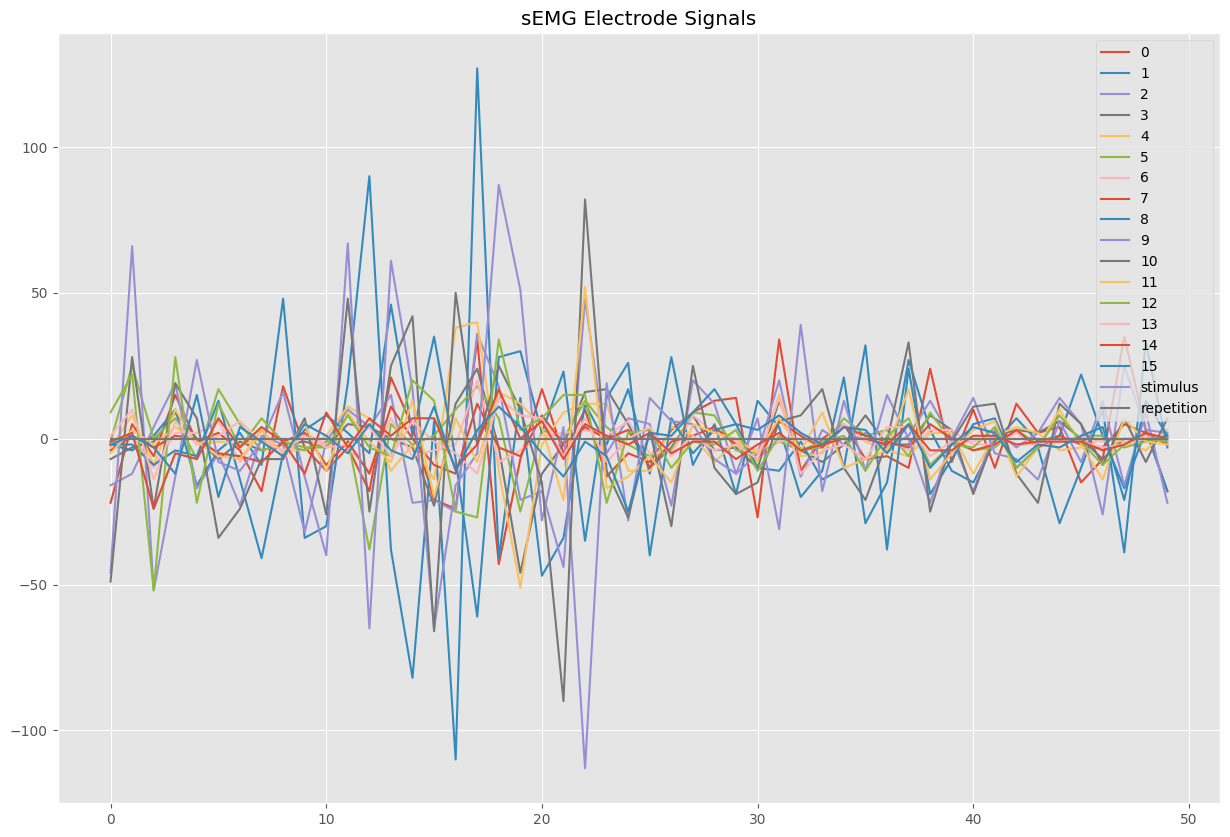

In [5]:
data_emg[:50].plot(figsize=(15,10), title="sEMG Electrode Signals")

In [6]:
# taken from section 3.3.1 of https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0186132 
train_set = [1, 3, 5, 6]
validation_set = [2, 5]

In [7]:
# the last column specifies the repetition number
np.unique(data_emg.values[:, 17])

array([0., 1., 2., 3., 4., 5., 6.], dtype=float32)

In [8]:
# TODO: DB5 specific right now, change so extracts by last column in general 
def normalize(data : pd.DataFrame, train_reps : list) -> pd.DataFrame:
    """
    Given sEMG data and exercise repetitions, extracts the subset of data corresponding by specification,
    which is centered and scaled to unit variance. 
    
    Parameters
    ----------
    data : pd.Dataframe 
        Collection of sensor data from which repetitions are to be extracted 
    train_reps : list 
        Specified exercise repetitions to extract by 
        
    Returns 
    -------
    pd.DataFrame
        Centered and unit-variance scaled sensor data for specified exercise repetitions

    """
    x = [np.where(data.values[:,17] == rep) for rep in train_reps]
    indices = np.squeeze(np.concatenate(x, axis = -1))
    train_data = data.iloc[indices, :].reset_index(drop=True)
    
    scaler = StandardScaler(with_mean=True,
                                with_std=True,
                                copy=False).fit(train_data.iloc[:, :16])
    
    scaled = scaler.transform(data.iloc[:,:16])
    normalized = pd.DataFrame(scaled)
    normalized['stimulus'], normalized['repetition'] = data['stimulus'], data['repetition']

    return normalized

<AxesSubplot: title={'center': 'Normalized sEMG Electrode Signals'}>

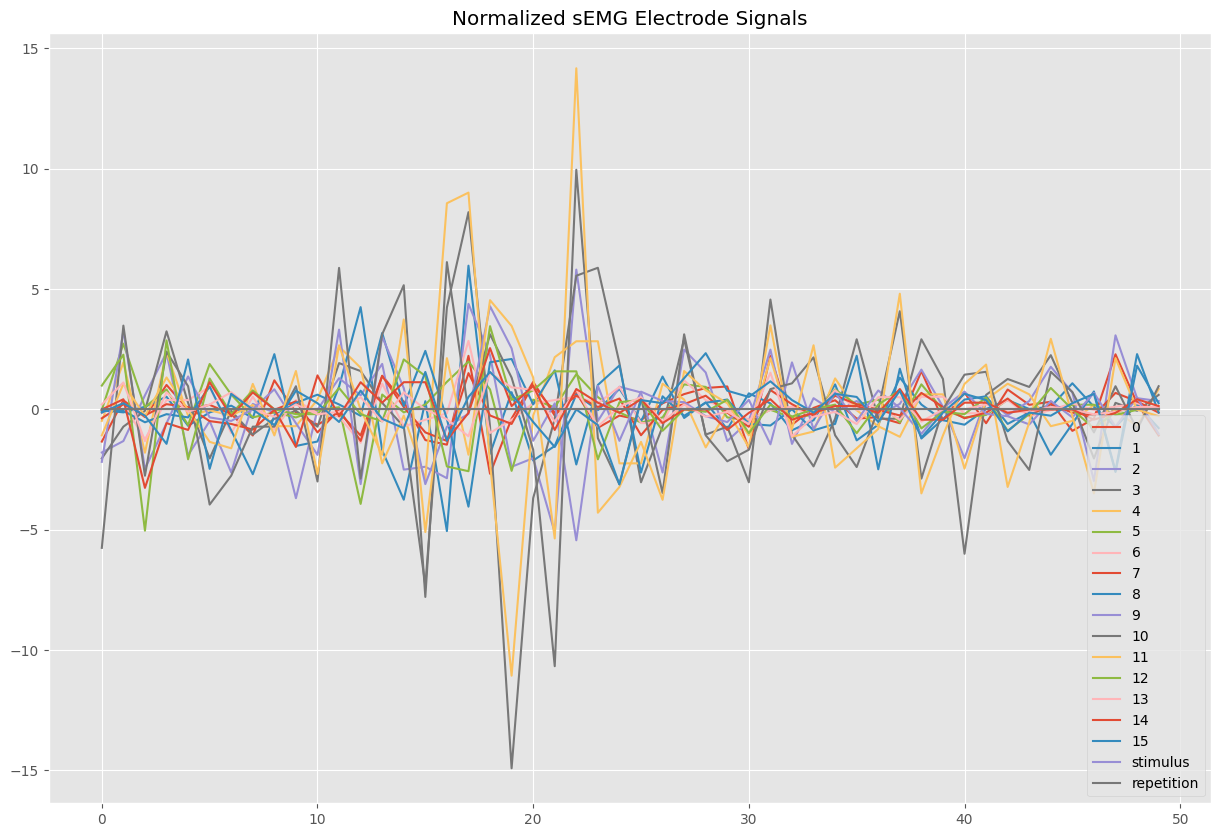

In [9]:
normalized_emg = normalize(data_emg, train_set)
normalized_emg[:50].plot(figsize=(15,10), title="Normalized sEMG Electrode Signals")

In [16]:
signature = iisignature.sig(normalized_emg, 2)

In [19]:
signature.shape
np.unique(normalized_emg.stimulus) # different gestures 

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int8)

In [10]:
data_glove = pd.DataFrame(mat['glove'])

<AxesSubplot: title={'center': 'Glove Electrode Signals'}>

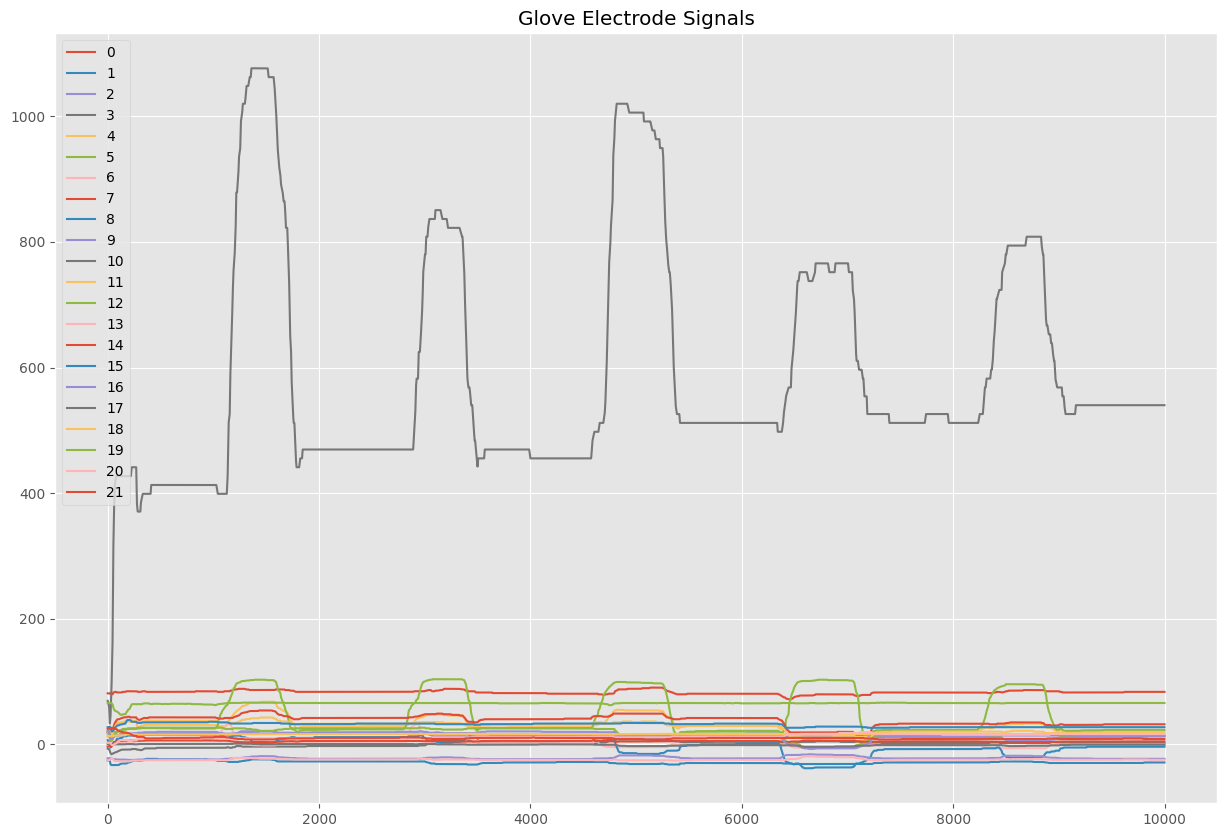

In [11]:
data_glove[:10000].plot(figsize=(15,10), title="Glove Electrode Signals")

In [12]:
print(f"Exercise number {mat['exercise'].item()}")
print(f"{mat['frequency'].item()} Hz")
print(mat['emg'].shape)
print(mat['glove'].shape)

Exercise number 3
200 Hz
(130267, 16)
(130267, 22)


In [13]:
level = 4
signature = iisignature.sig(mat['glove'], 2)

In [14]:
assert signature.shape[0] == 22 * 22 + 22